<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Amir Hossein Yari
### Student ID: 99102507

# Import necessary libraries

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [15]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Data Visualization

In [16]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

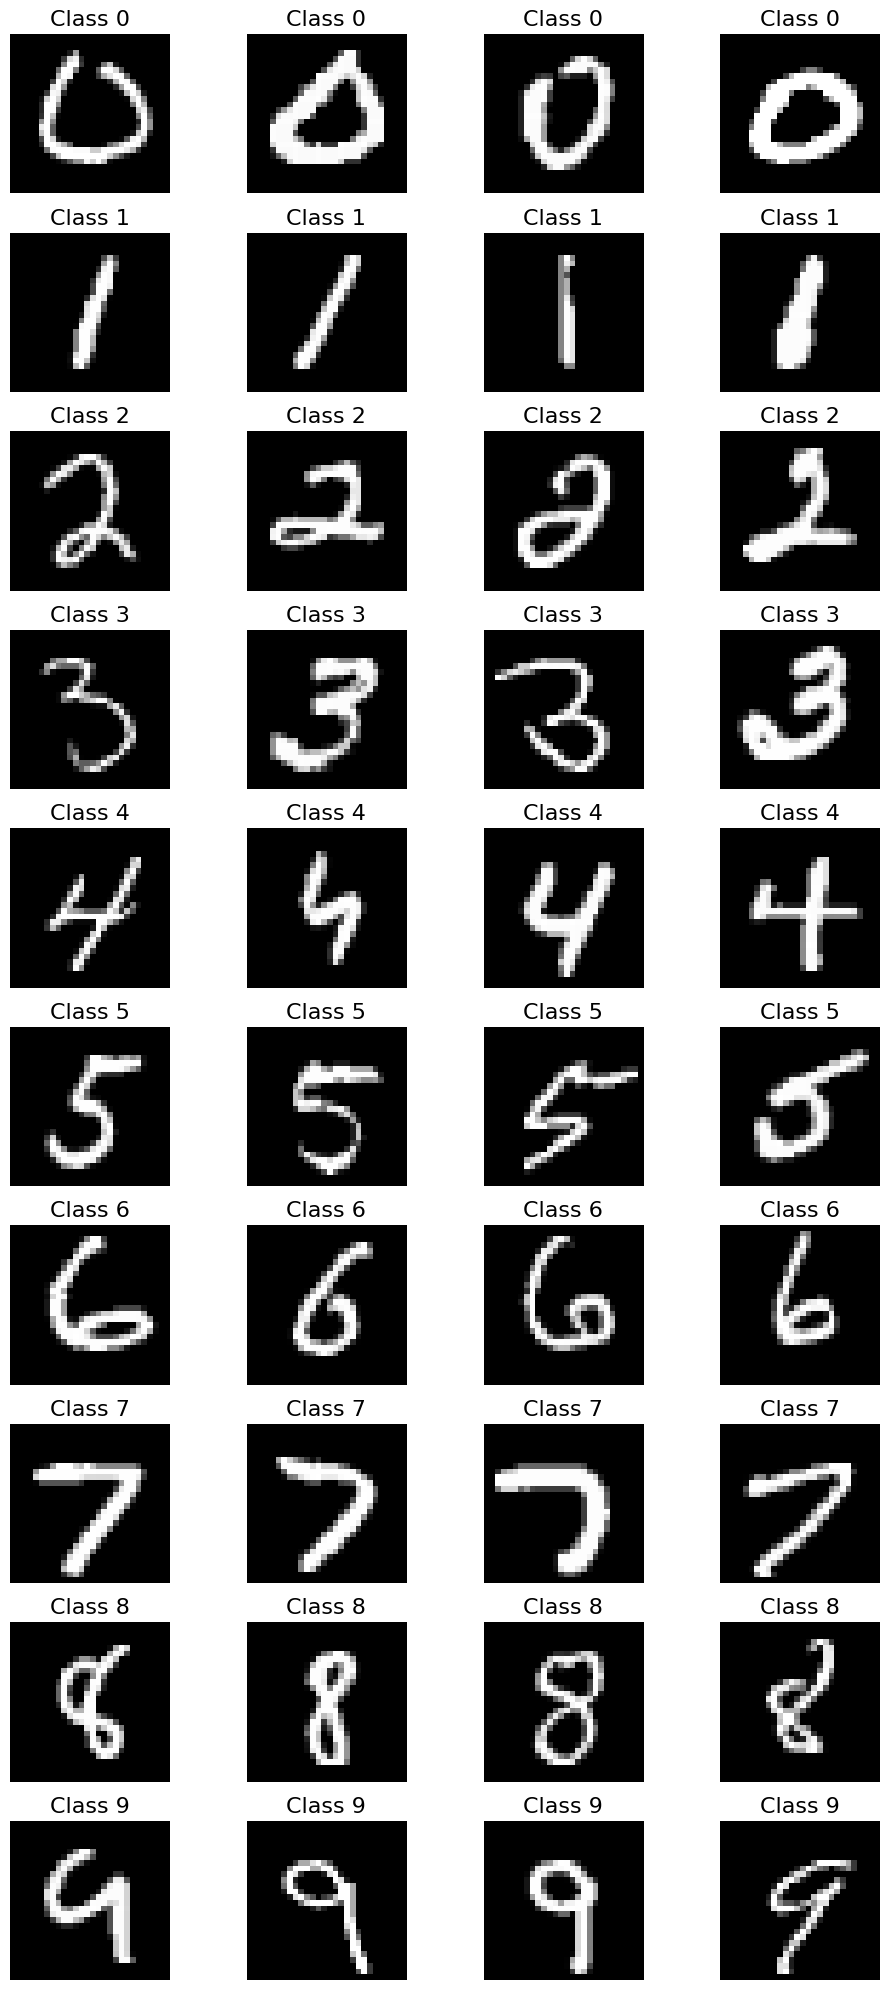

In [17]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [18]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)
        )
        # Latent space representation
        self.fc_mu = nn.Linear(latent_dim * 2, latent_dim)
        self.fc_logvar = nn.Linear(latent_dim * 2, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        x = x.view(-1, 784)
        # Encoder
        x = self.encoder(x)

        # Get latent variables
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # Reparameterization trick
        z = self.reparameterize(mu, logvar)

        # Decoder
        x_recon = self.decoder(z)

        return x_recon, mu, logvar

In [23]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # Reconstruction loss
    reconstruction_loss = F.mse_loss(recon, data, reduction='sum')

     # KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss as the sum of reconstruction and KL divergence losses
    total_loss = reconstruction_loss + kl_divergence

    return total_loss

In [24]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            # Forward process
            recon, mu, logvar = model(data)

            # Flatten the data and recon tensors
            data = data.view(-1, 784)
            recon = recon.view(-1, 784)

            # Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2).to(device)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # Save the best model to a file
    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")

In [25]:
# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


##################################################
VAE-MLP Epoch [1/10], Loss: 47.04273975423177
Sample Images:


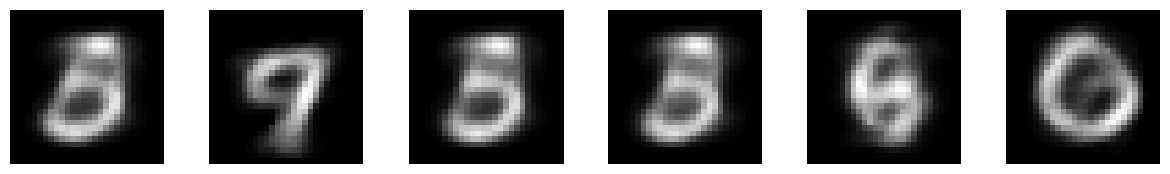


##################################################
VAE-MLP Epoch [2/10], Loss: 40.38950071614583
Sample Images:


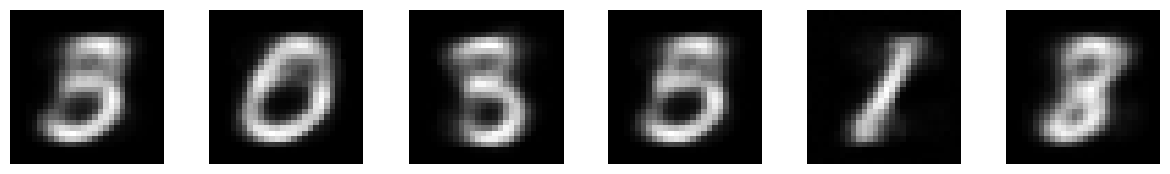


##################################################
VAE-MLP Epoch [3/10], Loss: 38.536322619628905
Sample Images:


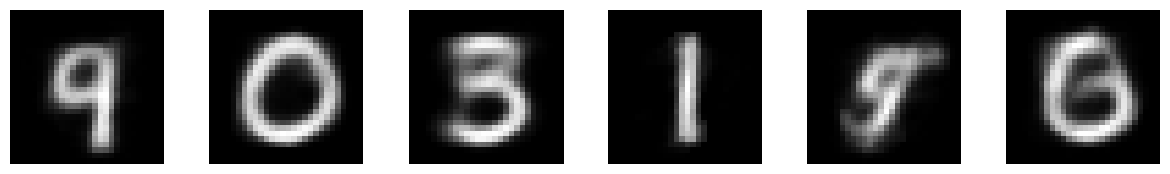


##################################################
VAE-MLP Epoch [4/10], Loss: 37.650959830729164
Sample Images:


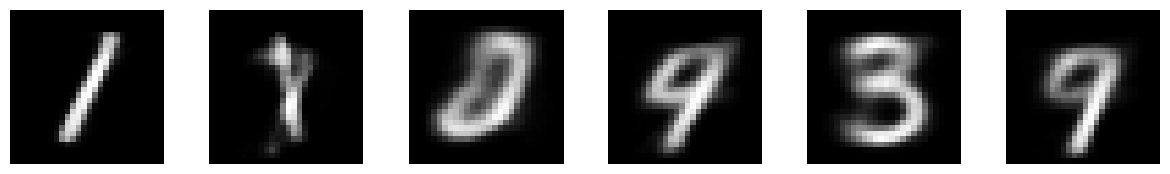


##################################################
VAE-MLP Epoch [5/10], Loss: 37.076539162190755
Sample Images:


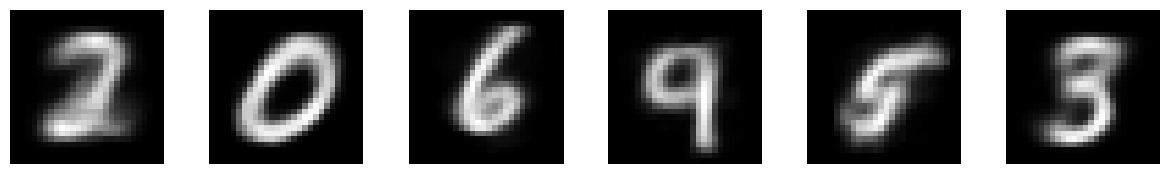


##################################################
VAE-MLP Epoch [6/10], Loss: 36.613380558268226
Sample Images:


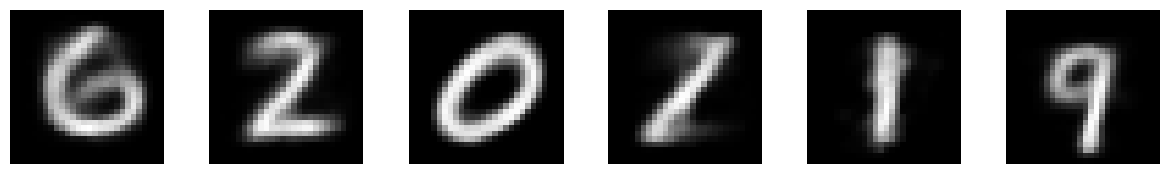


##################################################
VAE-MLP Epoch [7/10], Loss: 36.217320536295574
Sample Images:


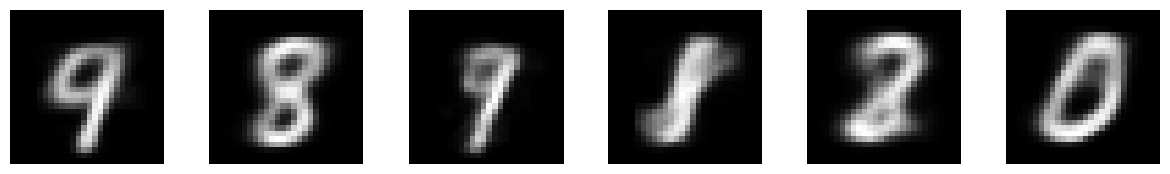


##################################################
VAE-MLP Epoch [8/10], Loss: 35.89977180379232
Sample Images:


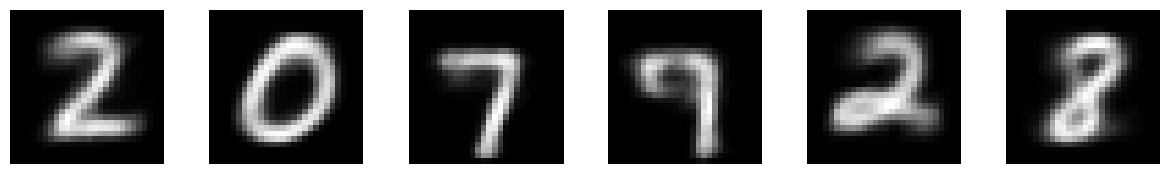


##################################################
VAE-MLP Epoch [9/10], Loss: 35.61483710327148
Sample Images:


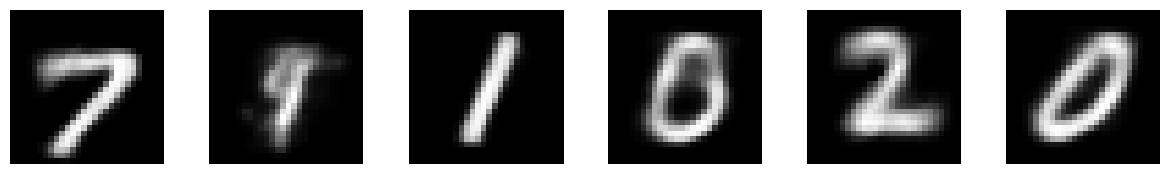


##################################################
VAE-MLP Epoch [10/10], Loss: 35.420870790608724
Sample Images:


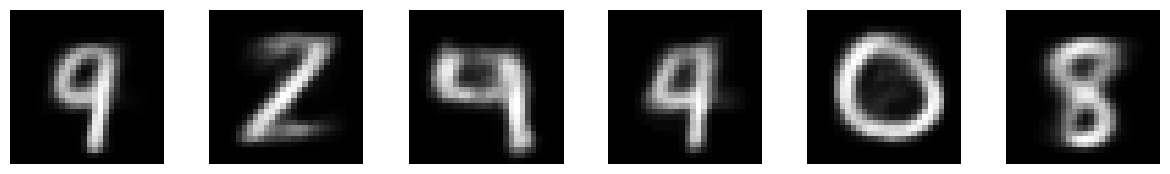

Best model saved as 'best_vae_mlp_model.pth'


In [26]:
# Train VAE-MLP
# Instantiate the VAE_MLP model
input_dim = 784
hidden_dim = 256
latent_dim = 2
vae_mlp = VAE_MLP(input_dim, hidden_dim, latent_dim)
train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [27]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_class = nn.Linear(hidden_dim, num_classes)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # Concatenate x and y before passing them to the encoder
        x = torch.cat([x, y], dim=1)

        # Encoder
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)

        # Classifier
        class_logits = self.fc_class(hidden)

        # Decoder
        decoded_input = torch.cat([z, y], dim=1)
        reconstructed = self.decoder(decoded_input)

        return reconstructed, mu, logvar, class_logits

In [39]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # Flatten the data tensor
    data = data.view(-1)

    # Reconstruction loss
    reconstruction_loss = F.mse_loss(recon.view(-1), data, reduction='sum')

    # KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels, reduction='sum')

    # Total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    total_loss = reconstruction_loss + kl_divergence + ce_loss

    return total_loss

In [40]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = F.one_hot(labels, num_classes=10).float()

            # Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            # Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2).to(device)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1).to(device)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # TODO: Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")


##################################################
CVAE-MLP Epoch [1/10], Loss: 40.551282124837236
Sample Images:


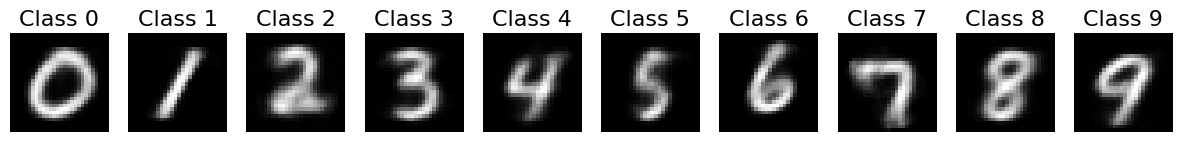


##################################################
CVAE-MLP Epoch [2/10], Loss: 32.71082887369791
Sample Images:


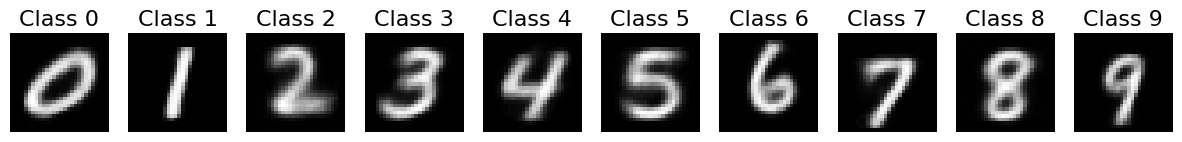


##################################################
CVAE-MLP Epoch [3/10], Loss: 31.610700111897785
Sample Images:


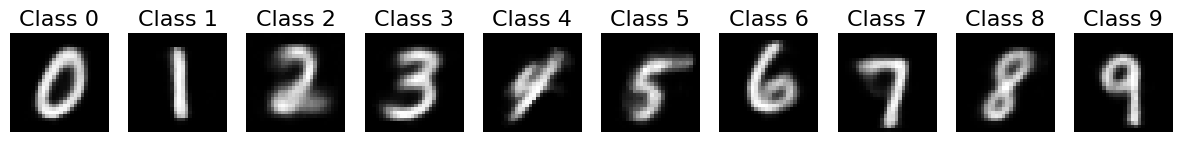


##################################################
CVAE-MLP Epoch [4/10], Loss: 31.049676947021485
Sample Images:


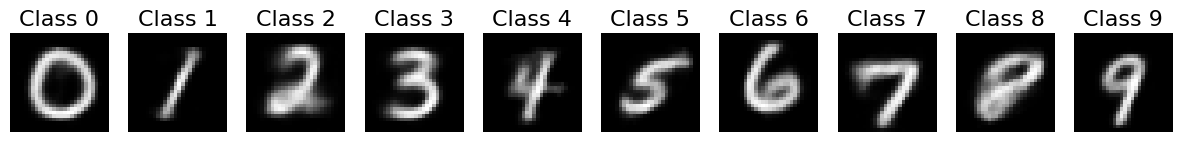


##################################################
CVAE-MLP Epoch [5/10], Loss: 30.723641658528646
Sample Images:


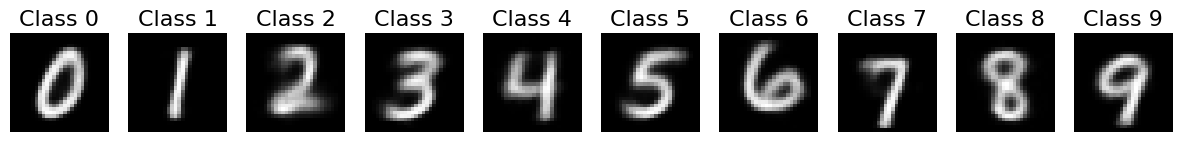


##################################################
CVAE-MLP Epoch [6/10], Loss: 30.517851747639973
Sample Images:


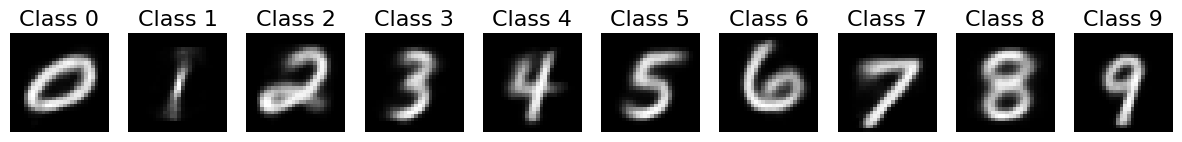


##################################################
CVAE-MLP Epoch [7/10], Loss: 30.331344349161785
Sample Images:


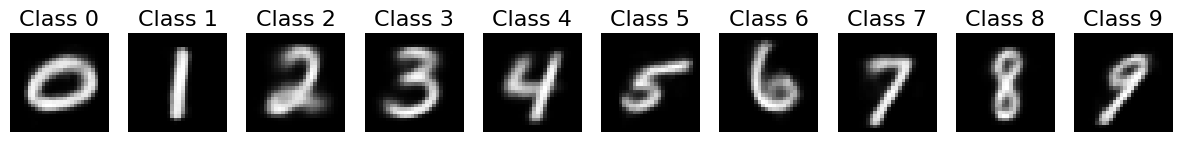


##################################################
CVAE-MLP Epoch [8/10], Loss: 30.21084123331706
Sample Images:


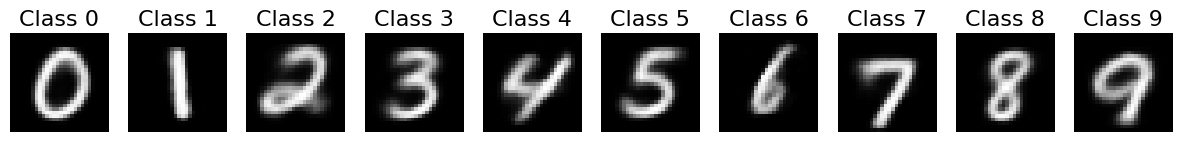


##################################################
CVAE-MLP Epoch [9/10], Loss: 30.08202067565918
Sample Images:


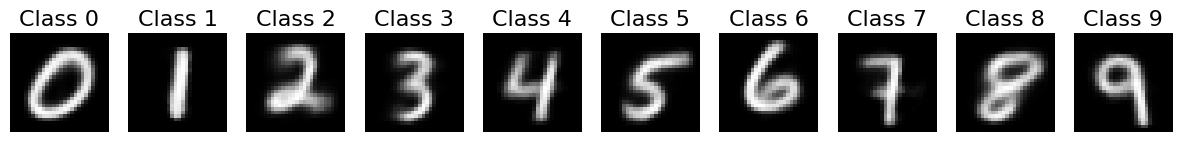


##################################################
CVAE-MLP Epoch [10/10], Loss: 29.985019474283853
Sample Images:


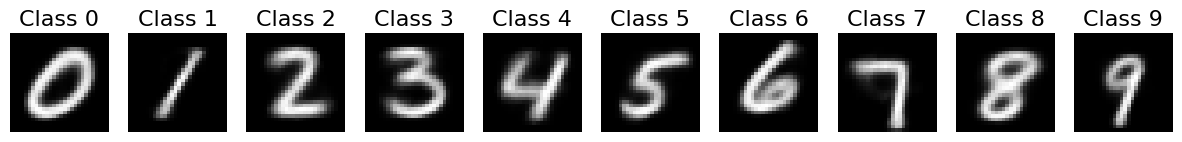

Best model saved as 'best_cvae_mlp_model.pth'


In [41]:
# Instantiate the CVAE_MLP model
input_dim = 784
hidden_dim = 256
latent_dim = 2
num_classes = 10
cvae_mlp = CVAE_MLP(input_dim, hidden_dim, latent_dim, num_classes)
# Train the CVAE-MLP model
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


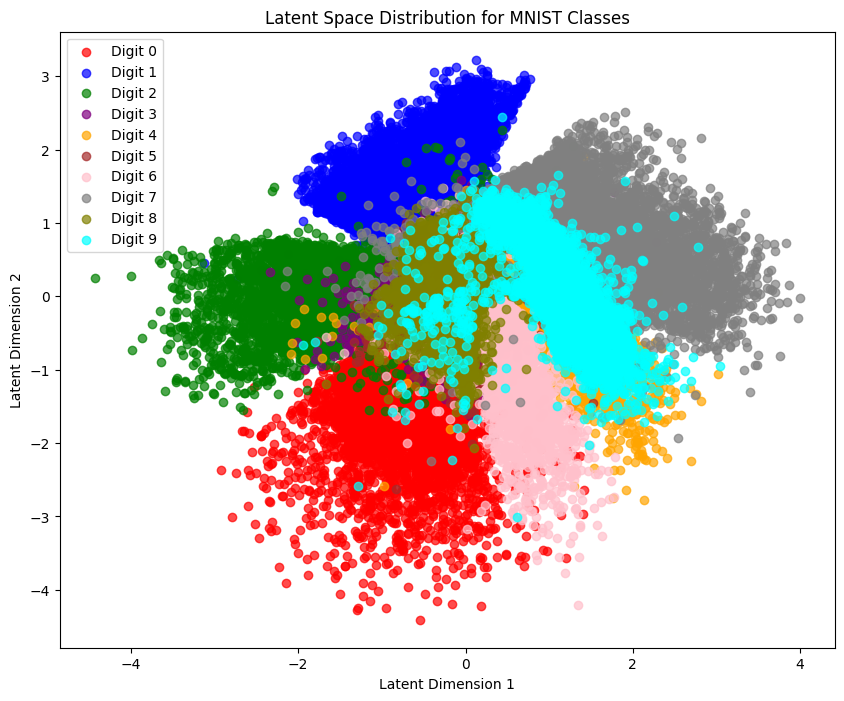

In [78]:
vae_mlp.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae_mlp.to(device)

# Function to encode samples and get latent space representations
def encode_samples(model, data_loader):
    latent_space = []
    labels = []

    for batch_idx, (data, label) in enumerate(data_loader):
        data = data.view(-1, 784).to(device)
        _, mu, _ = model(data)
        latent_space.append(mu.cpu())
        labels.extend(label.cpu().detach().numpy())

    latent_space = torch.cat(latent_space, dim=0)
    labels = torch.tensor(labels)

    return latent_space, labels

# Encode samples from each class
latent_space, labels = encode_samples(vae_mlp, train_loader)

# Define colors for each class
class_colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

# Visualize the latent space for each class with specific colors
plt.figure(figsize=(10, 8))
for i in range(10):
    indices = (labels == i).nonzero().view(-1)
    plt.scatter(latent_space[indices, 0].detach().numpy(), latent_space[indices, 1].detach().numpy(), label=f'Digit {i}', color=class_colors[i], alpha=0.7)

plt.title('Latent Space Distribution for MNIST Classes')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()
plt.show()

**Analysis of the latent space distribution for the MNIST dataset using Multilayer Perceptron (MLP) in VAE model**

* **Symmetry:** The clusters of digits in the latent space are approximatly arranged in a symmetrical manner. This suggests that the VAE model has learned to represent the digits in a way that is invariant to rotations and reflections.
* **Compactness:** The clusters of digits in the latent space are relatively compact, with little overlap between them. This indicates that the VAE model has learned to efficiently encode the digits in the latent space.
* **Separation:** The clusters of digits in the latent space are well-separated, with clear boundaries between them. This suggests that the VAE model has learned to effectively distinguish between the different digits.

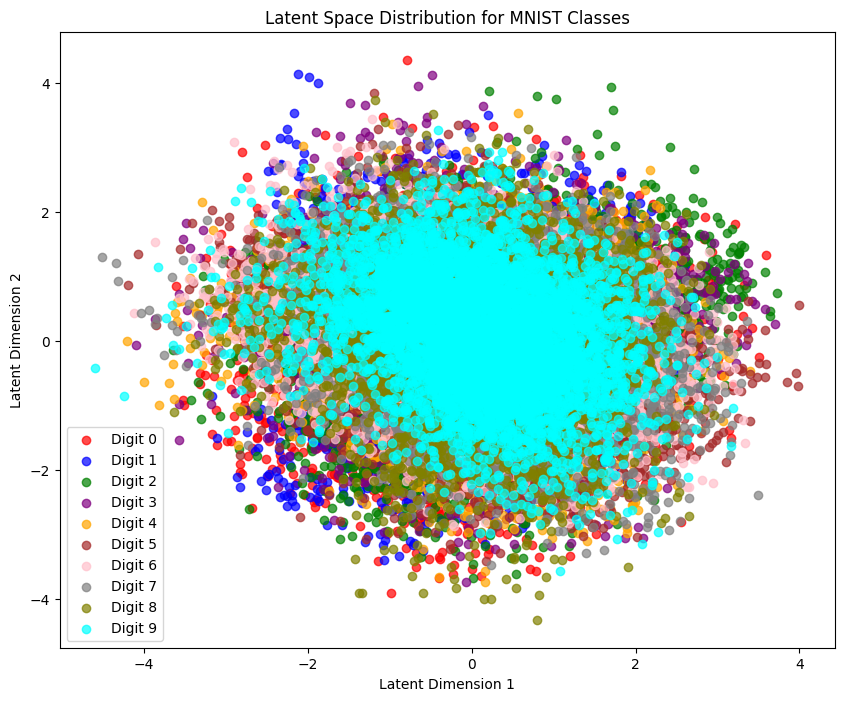

In [82]:
cvae_mlp.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cvae_mlp.to(device)

# Function to encode samples and get latent space representations
def encode_samples(model, data_loader):
    latent_space = []
    labels = []

    for batch_idx, (data, label) in enumerate(data_loader):
        data = data.view(-1, 784).to(device)
        label_one_hot = torch.eye(10)[label].to(device)
        _, mu, _, _ = model(data, label_one_hot)
        latent_space.append(mu.cpu())
        labels.extend(label.cpu().detach().numpy())

    latent_space = torch.cat(latent_space, dim=0)
    labels = torch.tensor(labels)

    return latent_space, labels

# Encode samples from each class
latent_space, labels = encode_samples(cvae_mlp, train_loader)

# Define colors for each class
class_colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

# Visualize the latent space for each class with specific colors
plt.figure(figsize=(10, 8))
for i in range(10):
    indices = (labels == i).nonzero().view(-1)
    plt.scatter(latent_space[indices, 0].detach().numpy(), latent_space[indices, 1].detach().numpy(), label=f'Digit {i}', color=class_colors[i], alpha=0.7)

plt.title('Latent Space Distribution for MNIST Classes')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()
plt.show()

In the context of the MNIST dataset, if the latent space is randomly sampled, VAE has no control over which digit will be generated. CVAE is able to address this problem by including a condition (a one-hot label) of the digit to produce. The condition is imposed on both the encoder and decoder inputs.